In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.special import erf
from sklearn.metrics import f1_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


# Defining funtions

In [4]:
def oh_encoder_data700k(df, experimento=1, n=400000):
    df = df.rename(columns={'is_malicious': 'label'})
    df = df.drop(['time'], axis=1)
    features = ['src_user', 'src_comp', 'dst_comp', 'label']
    
    df_train = df[features][df.label == 0][0:n]
    #df_test = df[features][df.label == 1]
    df_test = df[features][~df[features].dst_comp.isin(df_train.dst_comp.values) & \
                           ~df[features].src_user.isin(df_train.src_user.values)]
    
    y_test = df_test.label.values
    
    df_train = df_train.drop(['label'], axis=1)
    df_test = df_test.drop(['label'], axis=1)
    
    if(experimento == 1):
      df_train = df_train.drop(['src_comp'], axis=1)
      df_test = df_test.drop(['src_comp'], axis=1)
      features.remove('src_comp')
      fit = OneHotEncoder().fit(df[features[:-1]])
    else:
      df_train = df_train.drop(['src_user'], axis=1)
      df_test = df_test.drop(['src_user'], axis=1)
      features.remove('src_user')
      fit = OneHotEncoder().fit(df[features[:-1]])
    
    
    X_train = fit.transform(df_train.to_numpy()).toarray()
    X_test = fit.transform(df_test.to_numpy()).toarray()
    
    return X_train, X_test, y_test

def oh_encoder_data_unified_auth(df, experimento=1, percentage=0.6):
    df = df.drop(['time'], axis=1)
    features = ['computer_source', 'user', 'computer_dest', 'label']
    
    separator = int(percentage*len(df))

    df_train = df[features][df.label == 0][0:separator]
    #df_test = df[features][df.label == 1]
    df_test = df[features][~df[features].computer_dest.isin(df_train.computer_dest.values) & \
                           ~df[features].user.isin(df_train.user.values)]
    
    y_test = df_test.label.values
    
    df_train = df_train.drop(['label'], axis=1)
    df_test = df_test.drop(['label'], axis=1)
    
    if(experimento == 1):
      df_train = df_train.drop(['computer_source'], axis=1)
      df_test = df_test.drop(['computer_source'], axis=1)
      features.remove('computer_source')
      fit = OneHotEncoder().fit(df[features[:-1]])
    else:
      df_train = df_train.drop(['user'], axis=1)
      df_test = df_test.drop(['user'], axis=1)
      features.remove('user')
      fit = OneHotEncoder().fit(df[features[:-1]])
    
    
    X_train = fit.transform(df_train.to_numpy()).toarray()
    X_test = fit.transform(df_test.to_numpy()).toarray()
    
    return X_train, X_test, y_test

def get_percentile(scores, y_true):
    out_perc = np.size(np.where(y_true==1)) / len(y_true)
    per = np.percentile(scores, 100 * (1 - out_perc))
    return per

def standardizer(X_train, X_test, type='standard'):
    if type == 'standard':
        scaler = StandardScaler().fit(X_train)
    elif type == 'minmax' or type == 'min_max':
        scaler = MinMaxScaler().fit(X_train)
        
    return scaler.transform(X_train), scaler.transform(X_test)

class Lof(LocalOutlierFactor):
    def fit(self, X_train, y=None):
        self.X_train = X_train
        super().fit(X=X_train, y=y)
        return self

    def decision_function(self, X_test):
        return super().decision_function(X_test)

    def predict_proba(self, X_test):
        nof = self.negative_outlier_factor_ * -1
        test_scores = self.decision_function(X_test) * -1
        scaler = MinMaxScaler().fit(nof.reshape(-1, 1))
        proba = scaler.transform(test_scores.reshape(-1, 1))
        return proba.clip(0, 1)

# Handling datasets

In [7]:
df_700k = pd.read_csv("lanl-comprehensive_700k.csv")

In [8]:
df_700k.head()

,time,src_user,src_comp,dst_comp,is_malicious
0,1.0,ANONYMOUS LOGON@C586,C1250,C586,0
1,1.0,ANONYMOUS LOGON@C586,C586,C586,0
2,1.0,C1021$@DOM1,C1021,C625,0
3,1.0,C1035$@DOM1,C1035,C586,0
4,1.0,C1035$@DOM1,C586,C586,0


In [9]:
df_unified_auth = pd.read_csv("lanl-comprehensive-unified-auth.csv")

In [10]:
df_unified_auth.head()

,time,computer_source,user,computer_dest,label
0,87151,C288750,U451666,C313779,0
1,87451,C288750,U451666,C313779,0
2,100695,C206546,U457678,C639081,0
3,100695,C206546,U457678,C639081,0
4,101274,C206546,U416717,C825721,0


## Experimento 1 (lanl-comprehensive_700k)

In [47]:
X_train_Ex1, X_test_Ex1, y_test_Ex1 = oh_encoder_data700k(df_700k, experimento=1, n=70000)

In [48]:
X_train_norm_Ex1, X_test_norm_Ex1 = standardizer(X_train_Ex1, X_test_Ex1)

## Experimento 2 (lanl-comprehensive_700k)

In [49]:
X_train_Ex2, X_test_Ex2, y_test_Ex2 = oh_encoder_data700k(df_700k, experimento=2, n=70000)

In [50]:
X_train_norm_Ex2, X_test_norm_Ex2 = standardizer(X_train_Ex2, X_test_Ex2)

## Experimento 3 (lanl-comprehensive_unified-auth)

In [15]:
X_train_Ex3, X_test_Ex3, y_test_Ex3 = oh_encoder_data_unified_auth(df_unified_auth, experimento=1)

In [16]:
X_train_norm_Ex3, X_test_norm_Ex3 = standardizer(X_train_Ex3, X_test_Ex3)

## Experimento 4 (lanl-comprehensive_unified-auth)

In [17]:
X_train_Ex4, X_test_Ex4, y_test_Ex4 = oh_encoder_data_unified_auth(df_unified_auth, experimento=2)

In [18]:
X_train_norm_Ex4, X_test_norm_Ex4 = standardizer(X_train_Ex4, X_test_Ex4)

# Best K

In [45]:
'''n_range = tuple(range(10,80))
n_roc = []
n_av_precision = []
n_recall = []
n_f1 = []
    
for n in n_range:
    model = Lof(n_neighbors=n, novelty=True)    
    model.fit(X_train_norm_Ex1)
    test_scores_Ex1 = model_Ex1.predict_proba(X_test_norm_Ex1)
    
    roc = roc_auc_score(y_test_Ex1, test_scores_Ex1)
    n_roc.append(roc)
    ap_Ex1 = average_precision_score(y_test_Ex1, test_scores_Ex1)
    n_av_precision.append(ap_Ex1)
    per = get_percentile(test_scores_Ex1, y_test_Ex1.astype(int))    
    y_pred_Ex1 = (test_scores_Ex1>=per)

    roc_score_auc_Ex1 = roc_auc_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int)) 
    average_precision_Ex1 = average_precision_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int))
    precision_Ex1, recall_Ex1, f1_Ex1, _ = precision_recall_fscore_support(y_test_Ex1.astype(int),
                                                                           y_pred_Ex1.astype(int), average='binary')
    n_recall.append(recall_Ex1)
    n_f1.append(f1_Ex1)'''



"n_range = tuple(range(10,80))\nn_roc = []\nn_av_precision = []\nn_recall = []\nn_f1 = []\n    \nfor n in n_range:\n    model = Lof(n_neighbors=n, novelty=True)    \n    model.fit(X_train_norm_Ex1)\n    test_scores_Ex1 = model_Ex1.predict_proba(X_test_norm_Ex1)\n    \n    roc = roc_auc_score(y_test_Ex1, test_scores_Ex1)\n    n_roc.append(roc)\n    ap_Ex1 = average_precision_score(y_test_Ex1, test_scores_Ex1)\n    n_av_precision.append(ap_Ex1)\n    per = get_percentile(test_scores_Ex1, y_test_Ex1.astype(int))    \n    y_pred_Ex1 = (test_scores_Ex1>=per)\n\n    roc_score_auc_Ex1 = roc_auc_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int)) \n    average_precision_Ex1 = average_precision_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int))\n    precision_Ex1, recall_Ex1, f1_Ex1, _ = precision_recall_fscore_support(y_test_Ex1.astype(int),\n                                                                           y_pred_Ex1.astype(int), average='binary')\n    n_recall.append(recall_Ex1)

In [ ]:
'''plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy score vs N")
ax.plot(n_range, n_roc, marker='o', label="ROC")
ax.plot(n_range, n_av_precision, marker='o', label="Precision")
ax.plot(n_range, n_recall, marker='o', label="Recall")
ax.plot(n_range, n_f1, marker='o', label="F1")



for k, t, v, q, z in zip(n_range, n_roc, n_av_precision, n_recall, n_f1):
    if n % 4 == 0:
      plt.text(k, t, k)
      plt.text(k, v, k)
      plt.text(k, v, k)
      plt.text(k, v, k)
      plt.text(k, v, k)

ax.legend()
plt.show()'''

In [ ]:
'''best_values = max(zip(k_range, k_scores_train, k_scores_valid), key=lambda v:v[-1])
best_k, best_acc_train, best_acc_valid = best_values'''

# Train

## Experimento 1 (lanl-comprehensive_700k)

In [51]:
%%time
model_Ex1 = Lof(n_neighbors=10, novelty= True)
model_Ex1.fit(X_train_norm_Ex1)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex1 = model_Ex1.predict_proba(X_test_norm_Ex1)

Wall time: 13min 1s


## Experimento 2 (lanl-comprehensive_700k)

In [56]:
%%time
model_Ex2 = Lof(n_neighbors=10, novelty= True)
model_Ex2.fit(X_train_norm_Ex2)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex2 = model_Ex2.predict_proba(X_test_norm_Ex2)

Wall time: 8min 16s


## Experimento 3 (lanl-comprehensive_unified-auth)

In [21]:
%%time
model_Ex3 = Lof(n_neighbors=10, novelty= True)
model_Ex3.fit(X_train_norm_Ex3)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex3 = model_Ex3.predict_proba(X_test_norm_Ex3)

Wall time: 24.9 s


## Experimento 4 (lanl-comprehensive_unified-auth)

In [22]:
%%time
model_Ex4 = Lof(n_neighbors=10, novelty= True)
model_Ex4.fit(X_train_norm_Ex4)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex4 = model_Ex4.predict_proba(X_test_norm_Ex4)

Wall time: 21.4 s


# Metrics

## Experimento 1 (lanl-comprehensive_700k)

In [52]:
roc_Ex1 = roc_auc_score(y_test_Ex1, test_scores_Ex1)
ap_Ex1 = average_precision_score(y_test_Ex1, test_scores_Ex1)

print(f"ROC score: {roc_Ex1}")
print(f"Average precision score: {ap_Ex1}")

ROC score: 0.35250000000000004
Average precision score: 0.5771670190274841


In [53]:
per = get_percentile(test_scores_Ex1, y_test_Ex1.astype(int))    
y_pred_Ex1 = (test_scores_Ex1>=per)

roc_score_auc_Ex1 = roc_auc_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int)) 
average_precision_Ex1 = average_precision_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int))

precision_Ex1, recall_Ex1, f1_Ex1, _ = precision_recall_fscore_support(y_test_Ex1.astype(int),
                                                            y_pred_Ex1.astype(int),
                                                            average='binary')
print(f"F1: {f1_Ex1}")
print(f"Recall: {recall_Ex1}")

F1: 0.7319034852546916
Recall: 1.0


In [54]:
tn_Ex1, fp_Ex1, fn_Ex1, tp_Ex1 = confusion_matrix(y_test_Ex1, y_pred_Ex1).ravel()

print(f"True positives: {tp_Ex1}")
print(f"False positives: {fp_Ex1}")

True positives: 273
False positives: 200


## Experimento 2 (lanl-comprehensive_700k)

In [57]:
roc_Ex2 = roc_auc_score(y_test_Ex2, test_scores_Ex2)
ap_Ex2 = average_precision_score(y_test_Ex2, test_scores_Ex2)

print(f"ROC score: {roc_Ex2}")
print(f"Average precision score: {ap_Ex2}")

ROC score: 0.19999999999999996
Average precision score: 0.6290322580645161


In [58]:
per = get_percentile(test_scores_Ex2, y_test_Ex2.astype(int))    
y_pred_Ex2 = (test_scores_Ex2>=per)

roc_score_auc_Ex2 = roc_auc_score(y_test_Ex2.astype(int), y_pred_Ex2.astype(int)) 
average_precision_Ex2 = average_precision_score(y_test_Ex2.astype(int), y_pred_Ex2.astype(int))

precision_Ex2, recall_Ex2, f1_Ex2, _ = precision_recall_fscore_support(y_test_Ex2.astype(int),
                                                            y_pred_Ex2.astype(int),
                                                            average='binary')
print(f"F1: {f1_Ex2}")
print(f"Recall: {recall_Ex2}")

F1: 0.7722772277227723
Recall: 1.0


In [59]:
tn_Ex2, fp_Ex2, fn_Ex2, tp_Ex2 = confusion_matrix(y_test_Ex2, y_pred_Ex2).ravel()

print(f"True positives: {tp_Ex2}")
print(f"False positives: {fp_Ex2}")

True positives: 273
False positives: 161


## Experimento 3 (lanl-comprehensive_unified-auth)

In [31]:
roc_Ex3 = roc_auc_score(y_test_Ex3, test_scores_Ex3)
ap_Ex3 = average_precision_score(y_test_Ex3, test_scores_Ex3)

print(f"ROC score: {roc_Ex3}")
print(f"Average precision score: {ap_Ex3}")

ROC score: 0.5
Average precision score: 0.031746031746031744


In [32]:
per = get_percentile(test_scores_Ex3, y_test_Ex3.astype(int))    
y_pred_Ex3 = (test_scores_Ex3>=per)

roc_score_auc_Ex3 = roc_auc_score(y_test_Ex3.astype(int), y_pred_Ex3.astype(int)) 
average_precision_Ex3 = average_precision_score(y_test_Ex3.astype(int), y_pred_Ex3.astype(int))

precision_Ex3, recall_Ex3, f1_Ex3, _ = precision_recall_fscore_support(y_test_Ex3.astype(int),
                                                            y_pred_Ex3.astype(int),
                                                            average='binary')
print(f"F1: {f1_Ex3}")
print(f"Recall: {recall_Ex3}")

F1: 0.06153846153846154
Recall: 1.0


In [33]:
tn_Ex3, fp_Ex3, fn_Ex3, tp_Ex3 = confusion_matrix(y_test_Ex3, y_pred_Ex3).ravel()

print(f"True positives: {tp_Ex3}")
print(f"False positives: {fp_Ex3}")

True positives: 14
False positives: 427


## Experimento 4 (lanl-comprehensive_unified-auth)

In [34]:
ap_Ex4 = average_precision_score(y_test_Ex4, test_scores_Ex4)
roc_Ex4 = roc_auc_score(y_test_Ex4, test_scores_Ex4)

print(f"ROC score: {roc_Ex4}")
print(f"Average precision score: {ap_Ex4}")

ROC score: 0.9016393442622951
Average precision score: 0.25


In [35]:
per = get_percentile(test_scores_Ex4, y_test_Ex4.astype(int))    
y_pred_Ex4 = (test_scores_Ex4>=per)

roc_score_auc_Ex4 = roc_auc_score(y_test_Ex4.astype(int), y_pred_Ex4.astype(int)) 
average_precision_Ex4 = average_precision_score(y_test_Ex4.astype(int), y_pred_Ex4.astype(int))

precision_Ex4, recall_Ex4, f1_Ex4, _ = precision_recall_fscore_support(y_test_Ex4.astype(int),
                                                            y_pred_Ex4.astype(int),
                                                            average='binary')
print(f"F1: {f1_Ex4}")
print(f"Recall: {recall_Ex4}")

F1: 0.0
Recall: 0.0


In [36]:
tn_Ex4, fp_Ex4, fn_Ex4, tp_Ex4 = confusion_matrix(y_test_Ex4, y_pred_Ex4).ravel()

print(f"True positives: {tp_Ex4}")
print(f"False positives: {fp_Ex4}")

True positives: 0
False positives: 15


In [42]:
confusion_matrix(y_test_Ex4, y_pred_Ex4).ravel()

array([412,  15,  14,   0], dtype=int64)

# Graphic representation

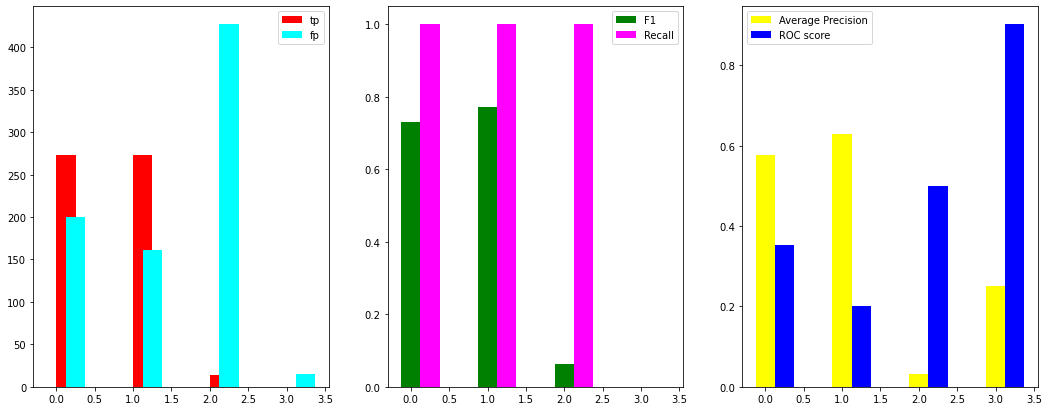

In [60]:
experimentos = ['Exprmnt 1','Exprmnt 2','Exprmnt 3','Exprmnt 4' ]
tps = [tp_Ex1,tp_Ex2,tp_Ex3,tp_Ex4]
fps = [fp_Ex1,fp_Ex2,fp_Ex3,fp_Ex4]
f1s = [f1_Ex1,f1_Ex2,f1_Ex3,f1_Ex4]
recalls = [recall_Ex1,recall_Ex2,recall_Ex3,recall_Ex4]
aps = [ap_Ex1,ap_Ex2,ap_Ex3,ap_Ex4]
rocs = [roc_Ex1,roc_Ex2,roc_Ex3,roc_Ex4]


fig, axs = plt.subplots(1,3,sharex=True,figsize =(18, 7))

barWidth = 0.25
br1 = np.arange(len(experimentos))
br2 = [x + barWidth for x in br1]

axs.flat[0].bar(br1,tps,color='red',width = barWidth,label="tp",align='edge')
axs.flat[0].bar(br2,fps,color='cyan',width = barWidth,label="fp")
#axs.flat[0].set_xticks([r + barWidth for r in range(len(experimentos))],
 #       experimentos)
axs.flat[0].legend()

axs.flat[1].bar(br1,f1s,color='green',width = barWidth,label="F1")
axs.flat[1].bar(br2,recalls,color='magenta',width = barWidth,label="Recall")
#axs.flat[1].set_xticks([r + barWidth for r in range(len(experimentos))],
 #       experimentos)
axs.flat[1].legend()

axs.flat[2].bar(br1,aps,color='yellow',width = barWidth,label="Average Precision")
axs.flat[2].bar(br2,rocs,color='blue',width = barWidth,label="ROC score")
#axs.flat[2].set_xticks([r + barWidth for r in range(len(experimentos))],
 #       experimentos)
axs.flat[2].legend()